# Introduction

This notebook shows how to create a neural networ to detect momo in images using Inception V3

# Imports

In [1]:
import numpy as np
import tensorflow as tf
import datetime; 
import pandas as pd
import matplotlib.pyplot as plt
import math
import csv
from time import time

from shutil import copy2, rmtree, copytree
from tqdm import tqdm
from sys import stdout
from os import listdir, makedirs, remove
from os.path import isfile, join, isdir, exists, dirname, abspath
from inspect import getsourcefile
from tensorflow import keras
from numpy.random import seed
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from itertools import product

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Downloading dataset from Github

In [2]:
![ ! -d "dataset" ] && echo "Cloning dataset project from github" && git clone https://github.com/alphonse92/momo-dataset.git ./dataset 
![ ! -d "visualization" ] && echo "Cloning visualization repo from github" && git clone https://github.com/alphonse92/uruit-ml-momo-test-visualization visualization 

!cd dataset       && git reset --hard && git pull && git checkout V2
!cd visualization && git reset --hard && git pull
!rm -rf result/ && cp -r visualization/result ./result

HEAD is now at 8f85f22 clean raw data
Already up to date.
Already on 'V2'
Your branch is up to date with 'origin/V2'.
HEAD is now at 2032732 get more data
Already up to date.


In [3]:
# Load Inception V3.

InceptionV3             = keras.applications.inception_v3.InceptionV3
     
preprocess_input        = keras.applications.inception_v3.preprocess_input
image                   = keras.preprocessing.image
     
ImageDataGenerator      = keras.preprocessing.image.ImageDataGenerator
Callback                = keras.callbacks
     
Model                   = keras.models.Model
Sequential              = keras.models.Sequential
layers                  = keras.layers
     
Input                   = layers.Input
Dense                   = layers.Dense
Conv2D                  = layers.Conv2D
ZeroPadding2D           = layers.ZeroPadding2D
BatchNormalization      = layers.BatchNormalization
AveragePooling2D        = layers.AveragePooling2D
MaxPooling2D            = layers.MaxPooling2D
GlobalAveragePooling2D  = layers.GlobalAveragePooling2D
Dropout                 = layers.Dropout



# Notebook Configuration 


In [4]:
# Notebook Configuration
USE_INCEPTION_V3_MODEL = True
RESET_TRAINING_EXAMPLES = True
SAVE_WEIGHTS = True
SEED_APP = 9

# DATASET PROPORTIONS
TRAINING_PERCENTAGE = 0.7
TESTING_PERCENTAGE  = 0.15
EVAL_PERCENTAGE     = 0.15

# HYPERPARAMETERS
CRITERIA_THRESHOLD = 0.7
EPOCHS = 10
EPOCHS_BOTTLENECK = 100
BATCH_SIZE = 15
IMG_W = IMG_H = 299

# MODEL CHECKPOINTS CONFIGURATION
SAVE_CHECKPOINTS = 2
SAVE_WEIGHTS_FREQUENCY = 'epoch'
SAVE_WEIGTHS_PERIOD = EPOCHS // SAVE_CHECKPOINTS

# COLAB SCOPE
MOUNT_G_DRIVE = False
GOOGLE_COLLAB = False                                                            # Default value. You should not modify this
GOOGLE_RESET_CONTENT_TREE = True                                                 # Reset the dataset content tree. It means remove and re copy the data from drive
MOUNT = "./"                                                                     # Base path of this project. You may not change this value   
G_MOUNT = "/content/drive"                                                       # Set where the drive folder will be mounted
G_PROJECT_PATH = G_MOUNT+ "/My Drive/Colab Notebooks/uruit-ml-momo-test/"        # Set the pathe where momo project is 

# If colab instance, then build the content tree
try:
  import google.colab
  from google.colab import drive
  if MOUNT_G_DRIVE: 
    drive.mount('/content/drive', force_remount=GOOGLE_RESET_CONTENT_TREE)
  GOOGLE_COLLAB = True
except:
  GOOGLE_COLLAB = False
  print(tf.test.gpu_device_name())
  

# Variables

In [5]:
tf.random.set_seed(SEED_APP)

MOMO_CLASSNAME    = "momo"
NO_MOMO_CLASSNAME = "no_momo"

DATASET_PATH = join(MOUNT, "dataset/")
DATESET_BASIC_PATH    = join(DATASET_PATH,'basic/')
DATESET_TRAINING_PATH = join(DATASET_PATH,'train/')
DATESET_TESTING_PATH  = join(DATASET_PATH,'test/')
DATESET_EVAL_PATH     = join(DATASET_PATH,'eval/')

RESULT_FOLDER_PATH = join(MOUNT,"result/")
VISUALIZATION_FOLDER = RESULT_FOLDER_PATH + "basic-predictions/"
VISUALIZATION_LATEST_RESULT_FOLDER = "latest/"

INCEPTION_V3_MODEL_NAME = "inception_v3"
BOTTLENECK_MODEL_NAME   = "bottleneck"

RESULT_FOLDER_WEIGHTS_INCEPTION_V3_PATH = RESULT_FOLDER_PATH + INCEPTION_V3_MODEL_NAME + "/"
RESULT_FOLDER_WEIGHTS_BOTTLENECK_PATH = RESULT_FOLDER_PATH +  INCEPTION_V3_MODEL_NAME+ "_" + BOTTLENECK_MODEL_NAME + "/"

DEFAULT_WEIGHTS_FILE_NAME = 'weights.h5'
DEFAULT_WEIGHTS_FILE_PATH = RESULT_FOLDER_WEIGHTS_INCEPTION_V3_PATH + DEFAULT_WEIGHTS_FILE_NAME
RESULT_FOLDER_WEIGHTS_BOTTLENECK_FILE_NAME = RESULT_FOLDER_WEIGHTS_BOTTLENECK_PATH + DEFAULT_WEIGHTS_FILE_NAME

  
performanceDF = pd.DataFrame()

print(DATESET_BASIC_PATH)

./dataset/basic/


# Functions

In [6]:
class ComposedBottleneckModel:
 
  def __init__(self,BaseModel,BottleneckModel):
      self.BaseModel = BaseModel            
      self.BottleneckModel = BottleneckModel

  def predict(self,imageArray):
    embdings   = self.BaseModel.predict(imageArray)
    prediction = self.BottleneckModel.predict(embdings)
    return prediction


def getDistribuitions(array,TRAINING_PERCENTAGE,TESTING_PERCENTAGE,EVAL_PERCENTAGE):
  m         = len(array)
  trainIdx  = math.ceil( m * TRAINING_PERCENTAGE )
  testIdx   = math.ceil( m * TESTING_PERCENTAGE  ) 
  evalIdx   = math.ceil( m * EVAL_PERCENTAGE     )     

  np.random.seed(SEED_APP)
  np.random.shuffle(array)

  currentIndex     = 0
  trainingImages   = array[ currentIndex : currentIndex + trainIdx ]

  currentIndex     = currentIndex + trainIdx 
  testImages       = array[ currentIndex : currentIndex + testIdx  ]

  currentIndex     = currentIndex + testIdx
  evalImages       = array[ currentIndex :          ]

  return {
      'train':trainingImages,
      'test' :testImages,
      'eval' :evalImages
  }

def getFolders(path):
    return [d for d in listdir(path) if isdir(join(path, d))]

def getFolderFiles(path: str):
    return [f for f in listdir(path) if isfile(join(path, f))]  


def predict(path, model) -> np.array:
    img = image.load_img(path, target_size=(299, 299))
    # Size  (299, 299, 3)
    imgArray = image.img_to_array(img) 
    
    # Size  (1, 299, 299, 3)
    expandedImgArray = np.expand_dims(imgArray, axis=0) 
    
    # Preproces to inceptionV3, normalize each pixel RGB value to an scale of zero to one
    processedImgArray = preprocess_input(expandedImgArray) 
    
    return model.predict(processedImgArray)

def getTimestamp():
    return datetime.datetime.now().timestamp()
    
def getRandomExample(xClass:str):
    np.random.seed(SEED_APP)
    exampleFileList = getFolderFiles(DATESET_BASIC_PATH + xClass)
    
    rndIndex = np.random.randint(0,len(exampleFileList))
    filename = exampleFileList[rndIndex]
    return join(DATESET_BASIC_PATH,xClass,filename)

def getDatasetClasses():
    return getFolders(DATESET_BASIC_PATH)

def getOutputClasses():
    return [NO_MOMO_CLASSNAME,MOMO_CLASSNAME]
    
def createFolderIfNotExist(folderPath):
    if not exists(folderPath):
        makedirs(folderPath)

def deleteIfExist(filepath):
    if exists(filepath):
        rmtree(filepath)
        
def resetFolderIfExist(path : str):
    deleteIfExist(path)
    createFolderIfNotExist(path)

def saveInFileIfNotExist(filepath: str, content: str):
  
    # Create (or not) the result folder
    createFolderIfNotExist(dirname(filepath))
    
    with open(filepath, mode="a") as f:
        f.write(content + '\n')
        

def plotModelTrainingProgress(progress):
  # Acc stats
  plt.plot(progress.history['accuracy'])
  plt.plot(progress.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.xlim(0, 1)
  plt.ylim(0, 1)
  plt.show()

  # Loss stats
  plt.plot(progress.history['loss'])
  plt.plot(progress.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.xlim(0, 1)
  plt.ylim(0, 1)
  plt.show()
  
def createConfusionMatrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]                
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
def getDataForConfusionMatrix(model):
    threshold = CRITERIA_THRESHOLD
    eval_Xs = []
    eval_Ys = []
    eval_preds = []
    files = []

    #folderPath = DATESET_TRAINING_PATH
    folderPath = DATESET_EVAL_PATH

    folders = getFolders(folderPath)

    for folder in folders:

        images                = getFolderFiles(folderPath+ folder)
        totalOfImagesInFolder = len(images)

        print("Processing" ,  folder , " total of images: ",totalOfImagesInFolder)

        for img in tqdm(images, file=stdout):
            src = folderPath + folder + "/" + img        
            files.append(src)
            result = predict(src,model)[0][0]

            # generamos una lista con las probabilidades devueltas por el modelo para cada imagen.
            eval_preds.append(result)

            # generamos nuestra lista de y_true, es decir la etiqueta de quebería tener la foto.
            eval_Xs.append(1 if folder == MOMO_CLASSNAME else 0)

            # generamos nuestra lista de y_pred, es decir la etiqueta que nos dio la predicción.
            eval_Ys.append(1 if result > threshold else 0)

    files      = np.array(files)
    eval_preds = np.array(eval_preds)
    eval_Xs    = np.array(eval_Xs)
    eval_Ys    = np.array(eval_Ys)
    
    momoModel.load_weights(DEFAULT_WEIGHTS_FILE_PATH)
    return (files,eval_preds,eval_Xs,eval_Ys)


def printConfussionMatrix(model):
  files,eval_preds,eval_Xs,eval_Ys = getDataForConfusionMatrix(model)
  createConfusionMatrix(
    eval_Xs,
    eval_Ys,
    title="Using bottleneck",
    classes=getOutputClasses(),
    normalize=True
)
        
def createInceptionModel():
  baseModel = InceptionV3(weights='imagenet', include_top=False, pooling=  'avg')
  baseModel.trainable = False
  
  # Take the output of the model
  x = baseModel.output

  # Add a full-conected layer of 1024 neurons with relu activation to our model output
  x = Dense(1024, activation='relu')(x)
  x = layers.Dropout(0.1)(x)
  #x = Dense(512, activation='relu')(x)

  # Add a output layer with only one neurone
  momoOutput = Dense(1, activation='sigmoid')(x)

  # Create the momo Model from our outputs
  model = Model(inputs=baseModel.input, outputs=momoOutput)

  for layer in baseModel.layers:
    layer.trainable = False

  # Compile our model using adam and an optimizer for binari clasification
  model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

  return model


# Preparing InceptionV3 Model to fit it to our problem: identify momo in. images

In [7]:
momoModel = createInceptionModel()

In [8]:
#print(momoModel.summary())

# Pre training

## Prepare our test/training folders

In [9]:
# Read each class of the dataset
for ds_class in getOutputClasses():
    # Create the folders in the train/test folders
    resetFolderIfExist( DATESET_TRAINING_PATH  +  ds_class  )
    resetFolderIfExist( DATESET_TESTING_PATH   +  ds_class  )
    resetFolderIfExist( DATESET_EVAL_PATH      +  ds_class  )


## Fill the train/test/eval folders

In [10]:
def CreateTrainTestAndEvalFolders():
    np.random.seed(SEED_APP)
    DATASET_CLASSES = getDatasetClasses()

    ds_folders = getFolders(DATESET_BASIC_PATH)

    for ds_folder in ds_folders:

        path      = DATESET_BASIC_PATH + ds_folder
        files     = np.array(getFolderFiles(path))


        distributions = getDistribuitions(files,
                          TRAINING_PERCENTAGE,
                          TESTING_PERCENTAGE,
                          EVAL_PERCENTAGE
        )

        trainingImages = distributions["train"]
        testImages     = distributions["test"]
        evalImages     = distributions["eval"]
        
        isPositiveClass      = ds_folder == MOMO_CLASSNAME
        folderTo             = MOMO_CLASSNAME if isPositiveClass else NO_MOMO_CLASSNAME

        trainingClassPath    = DATESET_TRAINING_PATH + folderTo
        testClassPath        = DATESET_TESTING_PATH  + folderTo
        evalClassPath        = DATESET_EVAL_PATH     + folderTo

        resetFolderIfExist(trainingClassPath)
        resetFolderIfExist(testClassPath)
        resetFolderIfExist(evalClassPath)


        print(
            "From folder '" + ds_folder  + "'"
            + " take " 
            + str(len(trainingImages)) + " Training examples, "
            + str(len(testImages))     + " Testing examples, and "
            + str(len(evalImages))     + " Eval examples."
            + "\n"        
        )

        print("Copying traning files from " + path + " to " + trainingClassPath)
        for imageName in tqdm(trainingImages, file=stdout):
            copy2(path+ "/"+  imageName ,trainingClassPath + "/"+  imageName)

        print("Copying testing files from " + path + " to " + testClassPath)
        for imageName in tqdm(testImages, file=stdout):
            copy2(path+ "/"+  imageName ,testClassPath + "/"+  imageName)

        print("Copying eval files from "    + path + " to " + evalClassPath)
        for imageName in tqdm(evalImages, file=stdout):
            copy2(path+ "/"+  imageName ,evalClassPath + "/"+  imageName)
        print()
        print()
            
CreateTrainTestAndEvalFolders()


From folder 'meme' take 91 Training examples, 20 Testing examples, and 19 Eval examples.

Copying traning files from ./dataset/basic/meme to ./dataset/train/no_momo
100%|██████████| 91/91 [00:00<00:00, 2614.42it/s]
Copying testing files from ./dataset/basic/meme to ./dataset/test/no_momo
100%|██████████| 20/20 [00:00<00:00, 2118.60it/s]
Copying eval files from ./dataset/basic/meme to ./dataset/eval/no_momo
100%|██████████| 19/19 [00:00<00:00, 2207.90it/s]


From folder 'landscapes' take 53 Training examples, 12 Testing examples, and 10 Eval examples.

Copying traning files from ./dataset/basic/landscapes to ./dataset/train/no_momo
100%|██████████| 53/53 [00:00<00:00, 2261.33it/s]
Copying testing files from ./dataset/basic/landscapes to ./dataset/test/no_momo
100%|██████████| 12/12 [00:00<00:00, 1523.54it/s]
Copying eval files from ./dataset/basic/landscapes to ./dataset/eval/no_momo
100%|██████████| 10/10 [00:00<00:00, 1686.49it/s]


From folder 'scary' take 61 Training examples, 13 Te


## Data augmentation

In [11]:
# Create a generator to pre process our dataset images
imageGenerator = ImageDataGenerator(
    rescale            = 1./255,       # Scale our data to our dataset scale
    horizontal_flip    = True,         # Horizontal mirror
    vertical_flip      = False,         # Disable vertical mirror
    rotation_range     = 7,
    width_shift_range  = 0.3,
    height_shift_range = 0.3,
    brightness_range   = (0.3, 0.7),
    shear_range        = 5.0,
    fill_mode          = "reflect"
)

trainGenerator = imageGenerator.flow_from_directory(
        directory   = DATESET_TRAINING_PATH,
        batch_size  =  BATCH_SIZE,
        class_mode  =  'binary',
        classes     =  getOutputClasses())

testGenerator= imageGenerator.flow_from_directory(
        directory    = DATESET_TESTING_PATH,

        batch_size   = BATCH_SIZE,
        class_mode   = 'binary',
        classes      = getOutputClasses())

Found 434 images belonging to 2 classes.
Found 94 images belonging to 2 classes.


In [12]:
trainGenerator.class_indices

{'momo': 1, 'no_momo': 0}

# Training

Lets save some util data from our foulders

In [13]:
trainPositiveFiles          = getFolderFiles(DATESET_TRAINING_PATH + MOMO_CLASSNAME)
trainNegativeFiles          = getFolderFiles(DATESET_TRAINING_PATH + NO_MOMO_CLASSNAME)
trainPositiveExamplesLength = len(trainPositiveFiles)
trainNegativeExamplesLength = len(trainNegativeFiles)
trainLength                 = trainPositiveExamplesLength + trainNegativeExamplesLength

print("Total train examples: ", trainLength , "positive: " , trainPositiveExamplesLength  , " negative: " , trainNegativeExamplesLength)

testPositiveFiles           = getFolderFiles(DATESET_TESTING_PATH + MOMO_CLASSNAME)
testNegativeFiles           = getFolderFiles(DATESET_TESTING_PATH + NO_MOMO_CLASSNAME)
testPositiveExamplesLength  = len(testPositiveFiles)
testNegativeExamplesLength  = len(testNegativeFiles)
testLength                  = testPositiveExamplesLength + testNegativeExamplesLength

print("Total test examples: ", testLength , "positive: " , testPositiveExamplesLength  , " negative: " , testNegativeExamplesLength)
print()

trainSteps = trainLength // BATCH_SIZE
testSteps  = testLength // BATCH_SIZE

print("Train Steps per epoch " , trainSteps)
print("Test Steps per epoch " , testSteps)


resetFolderIfExist(RESULT_FOLDER_WEIGHTS_INCEPTION_V3_PATH)


Total train examples:  434 positive:  304  negative:  130
Total test examples:  94 positive:  66  negative:  28

Train Steps per epoch  28
Test Steps per epoch  6


In [14]:
TRAINING_TIME_START = time()
progress = momoModel.fit_generator(
        trainGenerator,
        steps_per_epoch=trainSteps,
        epochs=EPOCHS,
        validation_data=testGenerator,
        validation_steps=testSteps
)
TRAINING_TIME_END = time()

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
28/28 [==============================] - 18s 654ms/step - loss: 0.6490 - accuracy: 0.8067 - val_loss: 0.0572 - val_accuracy: 0.9889
Epoch 2/10
28/28 [==============================] - 16s 577ms/step - loss: 0.1010 - accuracy: 0.9571 - val_loss: 0.2305 - val_accuracy: 0.9111
Epoch 3/10
28/28 [==============================] - 16s 578ms/step - loss: 0.0824 - accuracy: 0.9737 - val_loss: 0.0518 - val_accuracy: 0.9778
Epoch 4/10
28/28 [==============================] - 16s 573ms/step - loss: 0.1081 - accuracy: 0.9618 - val_loss: 0.1695 - val_accuracy: 0.9222
Epoch 5/10
28/28 [==============================] - 16s 580ms/step - loss: 0.0858 - accuracy: 0.9666 - val_loss: 0.0639 - val_accuracy: 0.9667
Epoch 6/10
28/28 [==============================] - 16s 582ms/step - loss: 0.0318 - accuracy: 0.9881 - val_loss: 0.0502 - val_accuracy: 0.9778
Epoch 7/10
28/28 [==============================] - 16s 582ms/step

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


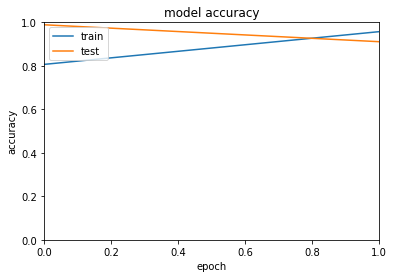

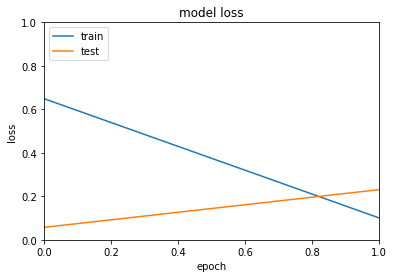

In [15]:
def saveInceptionV3CheckpointAndDraw():

  print(progress.history.keys())
  loss              = progress.history["loss"][-1]
  val_loss          = progress.history["val_loss"][-1]

  accuracy         = progress.history["accuracy"][-1]
  val_accuracy     = progress.history["val_accuracy"][-1]

  perfData = {
        'loss'         :  loss,             
        'val_loss'     :  val_loss,    
        'accuracy'     :  accuracy,    
        'val_accuracy' :  val_accuracy,
        'training_time':  (TRAINING_TIME_END - TRAINING_TIME_START),
        'train_length' :  trainLength,
        'test_length'  :  testLength
  }

  
  momoModel.save_weights( DEFAULT_WEIGHTS_FILE_PATH)
  plotModelTrainingProgress(progress)
  return perfData 

perfData = saveInceptionV3CheckpointAndDraw()
performanceDF = performanceDF.append(perfData, ignore_index=True)

Processing no_momo  total of images:  27
100%|██████████| 27/27 [00:04<00:00,  5.95it/s]
Processing momo  total of images:  64
100%|██████████| 64/64 [00:05<00:00, 11.56it/s]


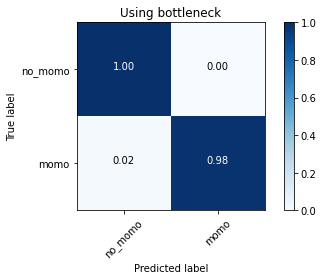

In [16]:
printConfussionMatrix(momoModel)

In [17]:
# View performance data
performanceDF.head()

,accuracy,loss,test_length,train_length,training_time,val_accuracy,val_loss
0,0.99284,0.025446,94.0,434.0,176.843293,1.0,0.016534


# Improving training time using a bottleneck model

Our model generalizes well, however this approach takes 15 seconds (aprox depending on your environmen) per epoch. We can improving this to 1 or less per sec. However, it will cost to us loss on train/testing set

First, we have all the embdings of our dataset in the follow at:

`/content/result/basic-predictions/latest/results.tsv`

This file contains all the 2048 embdings  generated by Inception V3. That data was pulled from the visualization repo. 

Lets do the next:

1. Read the embdings.
2. Read the metadata.
3. Build a new datasets where the input are the embdings and Y is [0,1] if its momo or not.
4. Build a bottleneck NN that receive the embdings and out the probability of be momo or not

*We need to be carefull because the embding files contains all the dataset, so we need to split the data in train, test and eval*

For this reason we need to use the `getDistribuitions` function

# Train using the embdings

## Create dataframes

In [18]:
resultsDF = pd.read_csv('result/basic-predictions/latest/result.csv')

In [19]:
resultsDF.head()

,class,image_name,predictions
0,landscapes,night_landscapes_image69.jpg,"0.18665837,0.2011668,0.27758992,0.4505339,0.67..."
1,landscapes,night_landscapes_image82.jpg,"0.121671416,0.33406463,0.18043913,0.037964597,..."
2,landscapes,night_landscapes_image1.jpg,"0.09562505,0.18875906,0.10296103,0.40914068,0...."
3,landscapes,night_landscapes_image97.jpg,"0.19299471,0.44939288,0.27516326,0.27659455,0...."
4,landscapes,night_landscapes_image54.jpg,"0.12543976,0.3352605,0.18066786,0.22412151,0.3..."


In [20]:
# Show where records are momo
resultsDF[resultsDF["class"].eq("momo")]

,class,image_name,predictions
476,momo,momo_image60.jpg,"0.24718286,0.32045782,0.45376766,0.029030561,0..."
477,momo,momo_image48.jpg,"0.91144085,1.1288024,0.27570406,0.35434362,0.0..."
478,momo,momo_noticiasimage33.jpg,"0.11241783,0.59009475,0.2327288,0.12253951,0.7..."
479,momo,momo_terror_image13.jpg,"0.6961774,0.86684567,0.48696104,0.233787,0.345..."
480,momo,momo_videoimage21.jpg,"0.867249,0.6748508,0.28455222,0.10471753,0.336..."
...,...,...,...
905,momo,momo_terror_image36.jpg,"0.61178976,0.12942956,0.27977118,0.4380286,0.1..."
906,momo,momo_terror_image22.jpg,"0.48330578,0.38772425,0.086077705,0.115843534,..."
907,momo,momo_image45.jpg,"0.41436443,0.6651123,0.35841405,1.2633588,0.03..."
908,momo,momo_historiaimage60.jpg,"0.108510874,0.2925446,0.022094179,0.41120535,0..."


In [21]:
# Take the Y array  and compare with the data above
resultsY = resultsDF["class"] == "momo"
resultsY = resultsY.to_list()


#lets verify the index (only for demonstration purposes)
isMomoArray = resultsDF["class"] == "momo"
index_error = False
for i in range(0,len(resultsDF["class"])):
  isMomo = isMomoArray[i]
  y_i    = resultsY[i]

  if  y_i !=  isMomo:
    index_error = True
    print("error",i)

if index_error :
  print("Error in indices")
else: 
  print("It is ok, all indices matchs each other")

print("rows:" , len(resultsDF["class"] == "momo"))


It is ok, all indices matchs each other
rows: 994


In [22]:
resultsY = [1 if result == True or result == 1 else 0 for result in resultsY] 
print("rows:" , len(resultsY))

rows: 994


## Get distributions from dataframes

In [23]:
# Get the predictions as float

arrayOfFeatures = resultsDF['predictions'].apply(lambda x: np.array([float(str_dim) for str_dim in x.split(',')], dtype=np.float32)).to_numpy().tolist()
embdings = pd.DataFrame(arrayOfFeatures)

embdings.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0.186658,0.201167,0.277590,0.450534,0.679752,0.557190,0.290200,0.049228,0.003357,0.435891,0.233772,0.372941,0.018152,0.220918,0.059483,0.287004,0.349816,0.399400,0.119716,0.076740,0.150059,0.081949,0.359989,0.139433,0.217959,0.141277,0.034335,0.325931,0.337279,1.040228,0.449910,0.664118,0.186733,0.202194,0.178565,0.343330,0.091849,0.120142,0.855181,0.431540,...,0.303280,0.412272,0.837927,0.451757,0.853336,0.359832,1.625067,0.369905,0.109124,0.000000,0.011018,0.509020,0.202400,0.532138,1.187709,0.011353,0.586955,0.484805,1.180369,0.171564,1.113664,0.577205,1.752373,0.423139,0.434294,0.013892,0.021528,0.819288,0.197840,1.136222,0.380921,0.814568,0.853492,1.155724,0.020632,0.197873,0.199785,0.090156,0.106479,0.198679
1,0.121671,0.334065,0.180439,0.037965,0.702711,0.480539,0.405303,0.106590,0.133642,0.714266,0.034964,0.097646,0.683623,0.259163,0.812722,0.273802,0.393268,0.832693,0.411869,1.396989,0.234263,0.211668,0.617950,0.065147,0.033820,0.138741,0.840643,0.389924,0.236197,0.297788,0.797041,0.263471,0.149280,0.091979,0.666626,0.170802,0.060599,0.645227,0.024508,0.222306,...,0.474003,0.326125,0.633693,0.259358,0.070400,0.185912,1.392322,0.150397,0.128107,0.273685,0.265904,1.109848,0.171083,1.015648,0.053169,0.048087,0.206891,0.000000,0.372582,0.720872,1.093609,0.060636,0.228902,0.055357,0.236972,0.415477,0.271191,0.219446,0.020738,1.132337,0.092776,0.179989,0.186551,0.491712,0.005300,0.017488,0.081028,0.116354,0.276918,0.309094
2,0.095625,0.188759,0.102961,0.409141,0.233870,0.178092,0.144872,0.684785,0.030607,0.205525,0.146331,0.326769,0.159326,0.340099,0.056878,0.600987,0.525919,0.425087,0.020922,0.267537,0.420028,0.051148,0.512424,0.032861,0.012830,0.731387,0.179493,0.481331,0.321772,0.481045,0.908872,0.135501,0.348812,0.052072,0.593057,0.310557,0.058454,0.270207,1.275407,0.155891,...,1.139673,0.615175,0.342320,0.121017,0.098823,0.789064,0.793131,0.181145,0.855039,0.020278,0.234760,0.117423,0.152047,0.897394,0.705481,0.405510,1.027417,0.164821,0.420691,0.494159,2.085188,1.124250,1.005321,0.799797,0.809275,0.003129,0.560752,0.195829,0.000000,0.290465,0.467819,0.025492,0.119554,2.963231,0.658304,0.136560,0.372603,0.064262,0.178026,1.056082
3,0.192995,0.449393,0.275163,0.276595,0.104226,0.313887,0.150739,0.241162,0.106343,0.232645,0.020406,0.117919,0.386289,0.146838,0.164870,0.582048,0.229578,0.226784,0.106215,0.335209,0.297369,0.020923,0.486241,0.090963,0.016745,0.490046,0.152940,0.396862,0.224672,1.045330,0.585388,0.186552,0.256583,0.075409,0.419912,0.400853,0.066843,0.069252,0.257802,0.144355,...,0.235505,0.545300,0.169635,0.596891,0.001234,0.034026,0.249636,0.024552,0.406844,0.339856,0.024830,0.953234,0.140756,0.223561,0.706568,0.850970,0.294396,0.081041,0.165759,0.282878,1.513223,0.151811,1.238532,0.511704,0.006007,0.269234,1.316672,0.011098,0.000804,1.006434,0.015888,0.165658,0.357495,1.568861,0.895973,0.219709,0.000000,0.086952,0.285739,0.036129
4,0.125440,0.335261,0.180668,0.224122,0.387346,0.053199,0.004590,0.341848,0.001810,0.477891,0.013860,0.488438,0.246895,0.413584,0.205500,0.345214,0.205500,0.383287,0.030998,0.148177,0.100476,0.129665,0.661583,0.426572,0.000000,0.677275,0.191681,0.621816,0.333985,0.516549,0.591228,0.380218,0.038230,0.086566,0.424608,0.429468,0.039960,0.129232,0.548597,0.071301,...,0.888134,0.227684,0.585849,0.555268,0.279131,0.004949,0.904657,0.011038,0.158753,0.399309,0.071014,0.659698,0.102262,1.030287,0.581589,0.084956,0.580619,0.118928,0.232220,0.734922,0.530656,0.064879,0.189440,0.267907,0.035129,0.073167,0.296866,0.205544,0.025095,0.959758,0.027288,0.089680,0.260602,0.787471,0.567632,0.152253,0.021113,0.000587,0.710166,0.512944
5,0.032018,0.024085,0.264659,0.041862,0.695062,0.204238

**Lets compare with the Dataframe predictions column**




In [24]:
resultsDF.head()

,class,image_name,predictions
0,landscapes,night_landscapes_image69.jpg,"0.18665837,0.2011668,0.27758992,0.4505339,0.67..."
1,landscapes,night_landscapes_image82.jpg,"0.121671416,0.33406463,0.18043913,0.037964597,..."
2,landscapes,night_landscapes_image1.jpg,"0.09562505,0.18875906,0.10296103,0.40914068,0...."
3,landscapes,night_landscapes_image97.jpg,"0.19299471,0.44939288,0.27516326,0.27659455,0...."
4,landscapes,night_landscapes_image54.jpg,"0.12543976,0.3352605,0.18066786,0.22412151,0.3..."


In [25]:
embdings_np = embdings.to_numpy()
y_np = np.array(resultsY)
y_np = y_np.reshape(len(y_np),1)
# Lets check the first embding to the first row.
print("Should match with the first record and the first item of predictions column of the table above" 
      , str(embdings_np[0][0])
)

print(y_np[0])


Should match with the first record and the first item of predictions column of the table above 0.1866583675146103
[0]


In [26]:
print(embdings_np.shape)
print(y_np.shape)

data_np = np.concatenate((embdings_np,y_np),axis=1)

# Only for visualization
data_df = pd.DataFrame(data_np)
data_df[data_df[2048].eq(1)].head(1)


(994, 2048)
(994, 1)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047,2048
476,0.247183,0.320458,0.453768,0.029031,0.306225,0.025471,0.004629,0.034889,0.007247,0.407783,0.184695,0.013441,0.115729,0.62249,0.501536,1.561765,0.256776,0.172202,0.119573,0.697882,0.150783,0.100919,0.325939,0.062293,0.31559,0.27122,0.009384,0.099966,0.568195,0.336057,0.62365,0.305853,0.260156,0.036168,0.449206,0.205906,0.03162,0.46075,0.226743,0.499222,...,0.511663,0.126905,0.0,0.606423,0.018816,0.199596,0.122246,0.084681,0.916436,0.900849,0.013232,0.27873,0.0,0.323366,0.909832,0.079706,0.038331,0.134642,0.414657,0.347676,0.016889,0.131062,0.389467,1.151315,0.655024,0.088533,0.151586,1.209917,0.859948,0.149463,0.248916,0.0,0.944593,0.164586,0.259422,0.261612,0.308517,0.009843,0.315403,1.0


Once we have the dataset from the  embdings, we will create the distributions to train, test and eval our bottleneck neural network

In [27]:
positives = []
negatives = []

print(len(data_np))

for i in range(0,len(data_np)):
  row = data_np[i]
  isPositive = int(row[-1]) == 1
  if isPositive:
    positives.append(row)
  else:
    negatives.append(row)

positives_np = np.array(positives)
negatives_np = np.array(negatives)

print("total positives",len(positives_np), "negatives" ,   len(negatives_np))

994
total positives 434 negatives 560


In [28]:

positive_distributions = getDistribuitions(positives_np, TRAINING_PERCENTAGE, TESTING_PERCENTAGE, EVAL_PERCENTAGE)
negative_distributions = getDistribuitions(negatives_np, TRAINING_PERCENTAGE, TESTING_PERCENTAGE, EVAL_PERCENTAGE)

train_positive = positive_distributions["train"]
test_positive  = positive_distributions["test"]
eval_positive  = positive_distributions["eval"]

train_negative = negative_distributions["train"]
test_negative  = negative_distributions["test"]
eval_negative  = negative_distributions["eval"]

print("Total of positive distribuitions","train:",len(train_positive),"test:",len(test_positive),"eval:",len(eval_positive))
print("Total of negative distribuitions","train:",len(train_negative),"test:",len(test_negative),"eval:",len(eval_negative))


Total of positive distribuitions train: 304 test: 66 eval: 64
Total of negative distribuitions train: 392 test: 84 eval: 84


In [29]:
train  = np.concatenate((train_positive,train_negative),axis=0)
test  = np.concatenate((test_positive,test_negative),axis=0)
eval  = np.concatenate((eval_positive,eval_negative),axis=0)

print("train shape" , train.shape)
print("test shape" , test.shape)
print("eval shape" , eval.shape)

train shape (696, 2049)
test shape (150, 2049)
eval shape (148, 2049)


## Train using the embdings

In [30]:
def createBottleneckNNModel(inputSize):

  model = Sequential()

  model = Sequential()
  model.add(Input(shape=(inputSize,)))
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.1))
  model.add(Dense(1, activation='sigmoid'))

  model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

  return model

inputSize = train.shape[1]-1
bottleneckModel = createBottleneckNNModel(inputSize)
bottleneckModel.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 256)               524544    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 524,801
Trainable params: 524,801
Non-trainable params: 0
_________________________________________________________________


In [31]:
train_x = train[:,0:-1]
train_y = train[:,-1]

test_x = test[:,0:-1]
test_y = test[:,-1]

TRAINING_TIME_START = time()
progress = bottleneckModel.fit(train_x, train_y,
          epochs=EPOCHS_BOTTLENECK,
          batch_size=BATCH_SIZE,
          validation_data=(test_x, test_y))
TRAINING_TIME_END = time()

Epoch 1/100
47/47 [==============================] - 0s 7ms/step - loss: 0.2372 - accuracy: 0.8994 - val_loss: 0.2494 - val_accuracy: 0.8933
Epoch 2/100
47/47 [==============================] - 0s 4ms/step - loss: 0.0896 - accuracy: 0.9655 - val_loss: 0.0954 - val_accuracy: 0.9600
Epoch 3/100
47/47 [==============================] - 0s 5ms/step - loss: 0.0428 - accuracy: 0.9871 - val_loss: 0.1276 - val_accuracy: 0.9533
Epoch 4/100
47/47 [==============================] - 0s 4ms/step - loss: 0.0240 - accuracy: 0.9957 - val_loss: 0.1111 - val_accuracy: 0.9533
Epoch 5/100
47/47 [==============================] - 0s 4ms/step - loss: 0.0209 - accuracy: 0.9943 - val_loss: 0.1098 - val_accuracy: 0.9667
Epoch 6/100
47/47 [==============================] - 0s 4ms/step - loss: 0.0082 - accuracy: 0.9986 - val_loss: 0.1210 - val_accuracy: 0.9533
Epoch 7/100
47/47 [==============================] - 0s 4ms/step - loss: 0.0047 - accuracy: 1.0000 - val_loss: 0.1087 - val_accuracy: 0.9533
Epoch 8/100
4

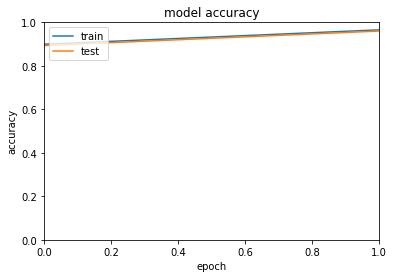

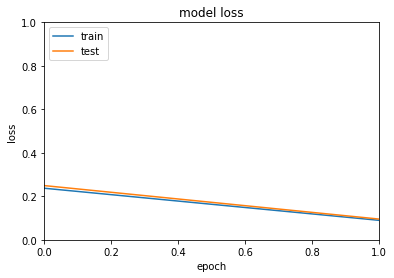

In [33]:
def saveInceptionV3WithBottleneckCheckpointAndDraw():

  createFolderIfNotExist(RESULT_FOLDER_WEIGHTS_BOTTLENECK_PATH)
  bottleneckModel.save_weights(RESULT_FOLDER_WEIGHTS_BOTTLENECK_FILE_NAME)
  
  loss              = progress.history["loss"][-1]
  val_loss          = progress.history["val_loss"][-1]

  accuracy         = progress.history["accuracy"][-1]
  val_accuracy     = progress.history["val_accuracy"][-1]

  perfData = {
        'loss'         :  loss,             
        'val_loss'     :  val_loss,    
        'accuracy'     :  accuracy,    
        'val_accuracy' :  val_accuracy,
        'training_time':  (TRAINING_TIME_END - TRAINING_TIME_START),
        'train_length' :  len(train_positive) + len(train_negative),
        'test_length'  :  len(test_positive ) + len(test_negative )
  }

  
  momoModel.save_weights( DEFAULT_WEIGHTS_FILE_PATH)
  plotModelTrainingProgress(progress)
  return perfData 

perfData = saveInceptionV3WithBottleneckCheckpointAndDraw()
performanceDF = performanceDF.append(perfData, ignore_index=True)


In [34]:
performanceDF.head()

,accuracy,loss,test_length,train_length,training_time,val_accuracy,val_loss
0,0.99284,0.025446,94.0,434.0,176.843293,1.000000,0.016534
1,1.00000,0.000010,150.0,696.0,19.237642,0.966667,0.206351


Processing no_momo  total of images:  27
100%|██████████| 27/27 [00:05<00:00,  5.25it/s]
Processing momo  total of images:  64
100%|██████████| 64/64 [00:08<00:00,  7.19it/s]


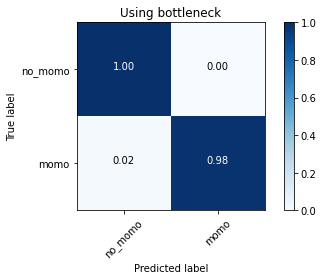

In [35]:
printConfussionMatrix(
    ComposedBottleneckModel(
          InceptionV3(weights='imagenet', include_top=False, pooling=  'avg'),
          bottleneckModel
    ) 
)

# Final Conclusions and thoughts
 
In this project, I evaluated two approaches to training a model. I got the same confusion matrix for both, however, using the second approach I'd got a significant improvement on training times, train/test acc/loss.

I consider the second approach is best because even it was trained with more data in train/set distribution, I got the best time and slightly difference between accuracy/loss on train/set distributions

In [36]:
momoModel.save(RESULT_FOLDER_WEIGHTS_INCEPTION_V3_PATH + "model")
bottleneckModel.save(RESULT_FOLDER_WEIGHTS_BOTTLENECK_PATH + "model")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./result/inception_v3/model/assets
INFO:tensorflow:Assets written to: ./result/inception_v3_bottleneck/model/assets


In [37]:
# Test if it was saved fine

momoModel2       = keras.models.load_model(RESULT_FOLDER_WEIGHTS_INCEPTION_V3_PATH + "model")
bottleneckModel2 = keras.models.load_model(RESULT_FOLDER_WEIGHTS_BOTTLENECK_PATH + "model")

In [40]:
momoModel2.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [41]:
bottleneckModel2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 256)               524544    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 524,801
Trainable params: 524,801
Non-trainable params: 0
_________________________________________________________________


In [38]:

!rm -rf dist dist.zip
!mkdir -p dist/inception_v3
!mkdir -p dist/bottleneck

!cp -r result/inception_v3/model dist/inception_v3
!cp -r result/inception_v3_bottleneck/model dist/bottleneck

!zip -r dist.zip dist

  adding: dist/ (stored 0%)
  adding: dist/bottleneck/ (stored 0%)
  adding: dist/bottleneck/model/ (stored 0%)
  adding: dist/bottleneck/model/variables/ (stored 0%)
  adding: dist/bottleneck/model/variables/variables.index (deflated 60%)
  adding: dist/bottleneck/model/variables/variables.data-00000-of-00001 (deflated 14%)
  adding: dist/bottleneck/model/assets/ (stored 0%)
  adding: dist/bottleneck/model/saved_model.pb (deflated 87%)
  adding: dist/inception_v3/ (stored 0%)
  adding: dist/inception_v3/model/ (stored 0%)
  adding: dist/inception_v3/model/variables/ (stored 0%)
  adding: dist/inception_v3/model/variables/variables.index (deflated 79%)
  adding: dist/inception_v3/model/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: dist/inception_v3/model/assets/ (stored 0%)
  adding: dist/inception_v3/model/saved_model.pb (deflated 93%)


In [39]:
if GOOGLE_COLLAB:
  from google.colab import files
  files.download("dist.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Next step

1. If you  ran this notebook on Colab, DO NOT FORGET TO DOWNLOAD the dist folder and start to use your model clasificator for images that contains momo

2. There is other notebook called detect_momo_in_videos that shows how to use our bottleneck model to detect momo images in videos.